# Reading in the data from VEP Output

In [1]:
# Ensure plots are shown inline in the notebook

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# https://useast.ensembl.org/info/genome/variation/prediction/predicted_data.html

In [3]:
def check_for_gene(dict, gene):
    # Step 1: Combine all dataframes into a single dataframe
    combined_df = pd.concat(dict.values(), keys=dict.keys(), names=['Sample'])
    combined_df = combined_df.reset_index(level='Sample')
    
    # Step 2: Filter for oncogenes
    all_genes = combined_df['Gene Symbol'].unique()

    return gene in all_genes

In [4]:
import pandas as pd

def read_vep_output(file_path):
    with open(file_path, 'r') as file:
        # Skip lines until the header is found
        for line in file:
            if line.startswith('#') and not line.startswith('##'):
                header = line[1:].strip().split('\t')  # Remove '#' and split the header
                break

    # Read the file into a pandas DataFrame, using the header found above
    df = pd.read_csv(file_path, comment='#', sep='\t', names=header, header=None)
    

    return df

In [5]:
import os

folder_path = '/bgfs/alee/LO_LAB/General/Lab_Data/20240628_WES_Rat_Neil/results/variant_calling/mutect2/'


dataframe_dict = {}

original_shapes = {}

for subfolder in os.listdir(folder_path):
    if subfolder.endswith('spleen'):
        vep_path = os.path.join(folder_path, subfolder, subfolder + ".mutect2.txt")
        vep_df = read_vep_output(vep_path)
        dataframe_dict[subfolder] = vep_df
        original_shapes[subfolder] = vep_df.shape
    else:
        continue

original_shapes

{'102_tumor_vs_102_spleen': (209106, 14),
 '116_tumor_vs_116_spleen': (207364, 14),
 '107_tumor_vs_107_spleen': (211221, 14),
 '158_tumor_vs_158_spleen': (213703, 14),
 '167_tumor_vs_167_spleen': (211040, 14),
 '157_tumor_vs_157_spleen': (202425, 14)}

In [6]:
def filter_vep_output(df):
    # Ensure the columns 'Gene' and 'Extra' exist in the DataFrame
    if 'Gene' not in df.columns or 'Extra' not in df.columns:
        raise ValueError("DataFrame must contain 'Gene' and 'Extra' columns.")
    
    # Filter for gene IDs that start with 'ENS'
    ens_filter = df['Gene'].str.startswith('ENS')
    
    # Filter for 'Extra' column containing 'IMPACT=HIGH' or 'IMPACT=MODERATE'
    high_impact_filter = df['Extra'].str.contains('IMPACT=HIGH')
    moderate_impact_filter = df['Extra'].str.contains('IMPACT=MODERATE')
    
    # Combine filters with correct grouping
    filtered_df = df[ens_filter & (high_impact_filter | moderate_impact_filter)]
    
    return filtered_df



In [7]:
filtered_dataframe_dict = {}
filtered_shapes = {}

for key, item in dataframe_dict.items():
    filtered_df = filter_vep_output(item)
    filtered_dataframe_dict[key] = filtered_df
    filtered_shapes[key] = filtered_df.shape

print(filtered_shapes)


{'102_tumor_vs_102_spleen': (883, 14), '116_tumor_vs_116_spleen': (813, 14), '107_tumor_vs_107_spleen': (949, 14), '158_tumor_vs_158_spleen': (1020, 14), '167_tumor_vs_167_spleen': (974, 14), '157_tumor_vs_157_spleen': (998, 14)}


In [8]:
from pybiomart import Dataset

def find_homologs(gene_ids):
    try:
        # Load the Ensembl dataset for rat genes
        rat_dataset = Dataset(name='rnorvegicus_gene_ensembl', host='http://www.ensembl.org')
        
        # Query the dataset for homologs of the rat gene using 'gene_id' filter
        result = rat_dataset.query(attributes=[
            'ensembl_gene_id', 
            'hsapiens_homolog_ensembl_gene'
        ], filters={'link_ensembl_gene_id': gene_ids})
        # Extract the homolog gene IDs if they exist
        if not result.empty:
            return result
    except Exception as e:
        print(f"Error finding homologs: {e}")
    return gene_ids, None


In [9]:
import sys


def chunk_list(lst, chunk_size):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]


homolog_dict = {}

for key, item in filtered_dataframe_dict.items():
    gene_ids = item["Gene"].tolist()

    
    # Initialize an empty dataframe to store the results
    all_results = pd.DataFrame()

    # Process each chunk of gene_ids
    for chunk in chunk_list(gene_ids, 200):
        results = find_homologs(chunk)
        all_results = pd.concat([all_results, results], ignore_index=True)
    
    
    # Merge the dataframes on the gene identifiers
    item = item.merge(all_results, left_on='Gene', right_on='Gene stable ID', how='left')
    
    # Rename the columns to match your desired output
    item.rename(columns={'Human gene stable ID': 'Homologs'}, inplace=True)
    
    # Drop the extra column if you don't need it
    item.drop(columns=['Gene stable ID'], inplace=True)


    item = item[item['Homologs'].notna()]
    homolog_dict[key] = item



In [10]:
from pybiomart import Dataset

def find_symbols(ensembl_ids):
    try:
        # Load the Ensembl dataset for rat genes

        dataset = Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')
        result = dataset.query(attributes=['ensembl_gene_id','external_gene_name', ],
                              filters={'link_ensembl_gene_id': ensembl_ids})

        # Extract the homolog gene IDs if they exist
        if not result.empty:
            return result
    except Exception as e:
        print(f"Error finding GeneSymbols for {ensembl_ids}: {e}")
    return ensembl_ids, None



In [11]:
import sys

def chunk_list(lst, chunk_size):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

symbol_dict = {}

for key, item in homolog_dict.items():
    ensembl_ids = item["Homologs"].tolist()


    # Initialize an empty dataframe to store the results
    all_results = pd.DataFrame()

    # Process each chunk of gene_ids
    for chunk in chunk_list(ensembl_ids, 200):
        results = find_symbols(chunk)
        all_results = pd.concat([all_results, results], ignore_index=True)
    
    # Merge the dataframes on the gene identifiers
    item = item.merge(all_results, left_on='Homologs', right_on='Gene stable ID', how='left')
    
    # Rename the columns to match your desired output
    item.rename(columns={'Gene name': 'Gene Symbol'}, inplace=True)

    # Drop the extra column if you don't need it
    item.drop(columns=['Gene stable ID'], inplace=True)


    item = item[item['Gene Symbol'].notna()]
    symbol_dict[key] = item


## Making the Oncoplot

Number of genes:  24


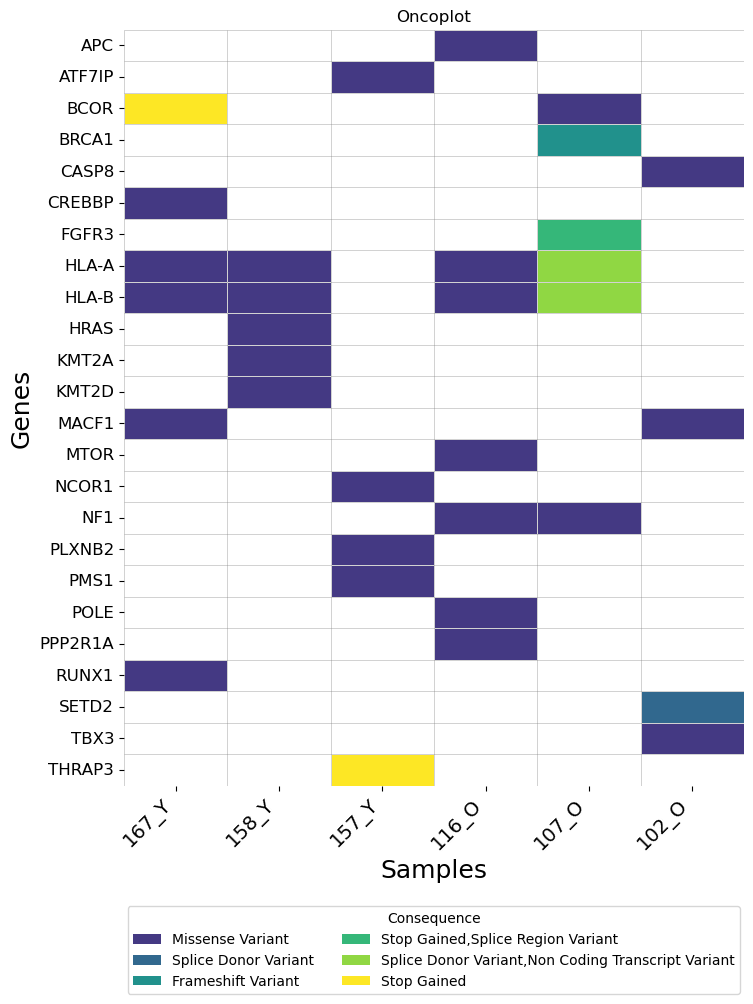

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
import sys
import os

# Function to classify genes using the OncoKB database
def classify_genes_oncokb(gene_list, oncokb_df):
    tsg_list = oncokb_df[oncokb_df['Is Tumor Suppressor Gene'] == 'Yes']['Hugo Symbol'].tolist()
    oncogene_list = oncokb_df[oncokb_df['Is Oncogene'] == 'Yes']['Hugo Symbol'].tolist()

    tsgs = [gene for gene in gene_list if gene in tsg_list]
    oncogenes = [gene for gene in gene_list if gene in oncogene_list]
    return tsgs + oncogenes

def classify_genes_brca(gene_list, brca_df):
    brca_list = brca_df['Gene'].tolist()
    genes = [gene for gene in gene_list if gene in brca_list]
    return genes

MODE = "BRCA"  # Can be "BRCA" or "ONCOKB"

# Assuming `symbol_dict` is already defined with sample_ids as keys and VEP output dataframes as values
if 'symbol_dict' not in globals():
    raise ValueError("symbol_dict is not defined.")

# Load the OncoKB database file
file_path = 'cancerGeneList.tsv'
oncokb_df = pd.read_csv(file_path, sep='\t')

brca_path = 'brca_genelist.csv'
brca_df = pd.read_csv(brca_path)

# Step 1: Combine all dataframes into a single dataframe
combined_df = pd.concat(symbol_dict.values(), keys=symbol_dict.keys(), names=['Sample'])
combined_df = combined_df.reset_index(level='Sample')

# Ensure necessary columns exist
if 'Gene Symbol' not in combined_df.columns or 'Extra' not in combined_df.columns:
    raise ValueError("combined_df must contain 'Gene Symbol' and 'Extra' columns.")

# Step 2: Filter for oncogenes
all_genes = combined_df['Gene Symbol'].unique()

if MODE == "ONCOKB":
    oncogenes = classify_genes_oncokb(all_genes, oncokb_df)
elif MODE == "BRCA":
    oncogenes = classify_genes_brca(all_genes, brca_df)

combined_df = combined_df[combined_df['Gene Symbol'].isin(oncogenes)]

# Step 3: Prepare data for plotting
# Extract IMPACT from the Extra column
combined_df['IMPACT'] = combined_df['Extra'].str.extract(r'IMPACT=([^;]+)')

# Sort by IMPACT, giving priority to 'HIGH' over 'MODERATE'
impact_priority = {'HIGH': 1, 'MODERATE': 2}
combined_df['IMPACT_PRIORITY'] = combined_df['IMPACT'].map(impact_priority)
combined_df = combined_df.sort_values(by=['Sample', 'Gene Symbol', 'IMPACT_PRIORITY'])

# Custom aggregation function to pick the most common consequence for each gene in each sample
def most_common_consequence(sub_df):
    return sub_df.sort_values(by='IMPACT_PRIORITY').iloc[0]

# Apply the custom aggregation function
agg_df = combined_df.groupby(['Sample', 'Gene Symbol'], as_index=False, group_keys=False).apply(most_common_consequence)

# Check if agg_df is correctly generated
if agg_df.empty:
    raise ValueError("agg_df is empty. Check your aggregation logic.")

# Create a pivot table
plot_data = agg_df.pivot_table(values='Consequence', index='Gene Symbol', columns='Sample', aggfunc='first')

# Step 4: Sort genes by mutation frequency
gene_mutation_freq = plot_data.notna().sum(axis=1).sort_values(ascending=False)
plot_data = plot_data.reindex(gene_mutation_freq.index)

# Step 5: Create a mapping of consequences to numbers for color-coding
unique_consequences = combined_df['Consequence'].unique()
consequence_map = {cons: i for i, cons in enumerate(unique_consequences)}

# Step 5: Create a mapping of consequences to numbers for color-coding
unique_consequences = combined_df['Consequence'].unique()
consequence_map = {cons: i+1 for i, cons in enumerate(unique_consequences)}  # Start from 1 instead of 0

# Replace consequences with their corresponding numbers
plot_data_numeric = plot_data.applymap(lambda x: consequence_map.get(x, 0))  # Use 0 for missing values

# Step 6: Create a custom colormap with white for missing values
n_colors = len(unique_consequences) + 1
colors = plt.cm.viridis(np.linspace(0, 1, n_colors))
colors[0] = [1, 1, 1, 1]  # Set the first color (index 0) to white
custom_cmap = ListedColormap(colors)


plot_data_numeric = plot_data_numeric.sort_index(ascending=False, axis = 1)
plot_data_numeric = plot_data_numeric.sort_index(ascending=True, axis = 0)


# Adjust figure height based on the number of genes
num_genes = plot_data_numeric.shape[0]
print("Number of genes: ", num_genes)
fig_height = max(num_genes * 0.5 * 0.4, num_genes * 0.5)  # Adjust the scaling factor as needed

# Step 7: Create the oncoplot
plt.figure(figsize=(8, fig_height))
ax = sns.heatmap(plot_data_numeric, cmap=custom_cmap, cbar=False, linewidths=0.5)

# Add custom gridlines with transparency
lines = []
for i in range(plot_data_numeric.shape[0] + 1):
    lines.append(((0, i), (plot_data_numeric.shape[1], i)))
for j in range(plot_data_numeric.shape[1] + 1):
    lines.append(((j, 0), (j, plot_data_numeric.shape[0])))

line_segments = LineCollection(lines, color='gray', linewidths=0.5, alpha=0.5)
ax.add_collection(line_segments)

plt.title('Oncoplot')
plt.xlabel('Samples')
plt.ylabel('Genes', fontsize = 18)

# Modify x-axis labels
current_labels = plt.gca().get_xticklabels()
num_labels = len(current_labels)

# Create new labels
new_labels = []
for i, label in enumerate(current_labels):
    suffix = '_Y' if i < 3 else '_O' if i >= num_labels - 3 else 'Rat '
    new_labels.append(label.get_text()[:3] + suffix)

plt.gca().set_xticklabels(new_labels, fontsize = 14)
plt.xlabel('Samples', fontsize = 18)
# Increase y-tick label font size
plt.yticks(fontsize=12)
# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust the plot to make space for the legend
plt.subplots_adjust(bottom=0.25)

# Create a custom legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[consequence_map[cons]], 
                                 edgecolor='none', label=cons.replace('_', ' ').title()) for cons in unique_consequences]
plt.legend(handles=legend_elements, title='Consequence', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)

# Save the plot as an SVG file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "oncoplot.svg")
plt.savefig(output_file, format='svg')


## Calculating and plotting TMB

                     Sample  Total Count       TMB
76  167_tumor_vs_167_spleen          974  13.71831
72  167_tumor_vs_167_spleen          974  13.71831
74  167_tumor_vs_167_spleen          974  13.71831
75  167_tumor_vs_167_spleen          974  13.71831
71  167_tumor_vs_167_spleen          974  13.71831
..                      ...          ...       ...
15  102_tumor_vs_102_spleen          883  12.43662
16  102_tumor_vs_102_spleen          883  12.43662
17  102_tumor_vs_102_spleen          883  12.43662
18  102_tumor_vs_102_spleen          883  12.43662
0   102_tumor_vs_102_spleen          883  12.43662

[102 rows x 3 columns]
['167_tumor_vs_167_spleen', '158_tumor_vs_158_spleen', '157_tumor_vs_157_spleen', '116_tumor_vs_116_spleen', '107_tumor_vs_107_spleen', '102_tumor_vs_102_spleen']


/scratch/slurm-954308/ipykernel_47625/2198534913.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels)


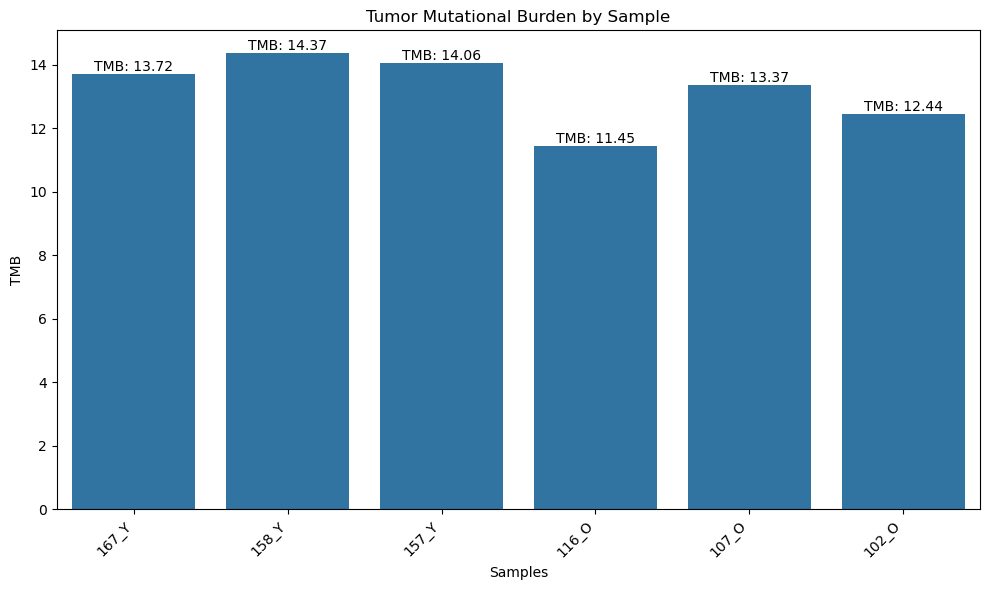

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Foley, J.F., Phadke, D.P., Hardy, O. et al. Whole exome sequencing in the rat. BMC Genomics 19, 487 (2018). https://doi.org/10.1186/s12864-018-4858-8
def calculate_tmb(df, mb_covered=71):  
    return len(df) / mb_covered

# Calculate TMB and total counts for each sample
tmb_dict = {}
total_counts = {}
for sample, df in filtered_dataframe_dict.items():
    tmb = calculate_tmb(df)
    total_count = len(df)
    tmb_dict[sample] = tmb
    total_counts[sample] = total_count

# # Sort samples by total count (descending order)
# sorted_samples = sorted(total_counts.items(), key=lambda x: x[1], reverse=False)
# sample_order = [sample for sample, _ in sorted_samples]

# Prepare data for plotting
plot_data = []
for sample, _ in filtered_dataframe_dict.items():
    df = filtered_dataframe_dict[sample]
    consequences = df['Consequence'].value_counts()
    for consequence, count in consequences.items():
        plot_data.append({
            'Sample': sample,
#            'Consequence': consequence,
            'Total Count': total_counts[sample],
            'TMB': tmb_dict[sample]
        })

plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.loc[plot_df['Sample'].apply(lambda x: int(x.split('_')[0])).sort_values(ascending=False).index]

print(plot_df)

# Create a thick bar plot for each tumor
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Sample', y='TMB', data=plot_df, )

# Customize the plot
plt.title('Tumor Mutational Burden by Sample')
plt.xlabel('Sample')
plt.ylabel('TMB')
plt.xticks(rotation=90)

samples = ['116_tumor_vs_116_spleen', '102_tumor_vs_102_spleen', '107_tumor_vs_107_spleen', '167_tumor_vs_167_spleen', '157_tumor_vs_157_spleen', '158_tumor_vs_158_spleen']
sample_order  = sorted(samples, reverse=True, key=lambda x: int(x[:3]))

print(sample_order)
# Add TMB values on top of each bar

for i, sample in enumerate(sample_order):
    tmb = tmb_dict[sample]
    total_count = total_counts[sample]
    ax.text(i, tmb , f'TMB: {tmb:.2f}', ha='center', va='bottom')

# Modify x-axis labels

# Modify x-axis labels
current_labels = plt.gca().get_xticklabels()
num_labels = len(current_labels)

# Create new labels
new_labels = []
for i, label in enumerate(current_labels):
    suffix = '_Y' if i < 3 else '_O' if i >= num_labels - 3 else 'Rat '
    new_labels.append(label.get_text()[:3]+suffix)

plt.gca().set_xticklabels(new_labels)
plt.xlabel('Samples')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout and show the plot
plt.tight_layout()
# Save the plot as an SVG file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "tmb.svg")
plt.savefig(output_file, format='svg')


{'102_tumor_vs_102_spleen': 12.43661971830986, '116_tumor_vs_116_spleen': 11.450704225352112, '107_tumor_vs_107_spleen': 13.366197183098592, '158_tumor_vs_158_spleen': 14.366197183098592, '167_tumor_vs_167_spleen': 13.71830985915493, '157_tumor_vs_157_spleen': 14.056338028169014}
                    Sample Age Group        TMB
4  167_tumor_vs_167_spleen     Young  13.718310
3  158_tumor_vs_158_spleen     Young  14.366197
5  157_tumor_vs_157_spleen     Young  14.056338
1  116_tumor_vs_116_spleen       Old  11.450704
2  107_tumor_vs_107_spleen       Old  13.366197
0  102_tumor_vs_102_spleen       Old  12.436620
167_tumor_vs_167_spleen: TMB = 13.72
158_tumor_vs_158_spleen: TMB = 14.37
157_tumor_vs_157_spleen: TMB = 14.06
116_tumor_vs_116_spleen: TMB = 11.45
107_tumor_vs_107_spleen: TMB = 13.37
102_tumor_vs_102_spleen: TMB = 12.44


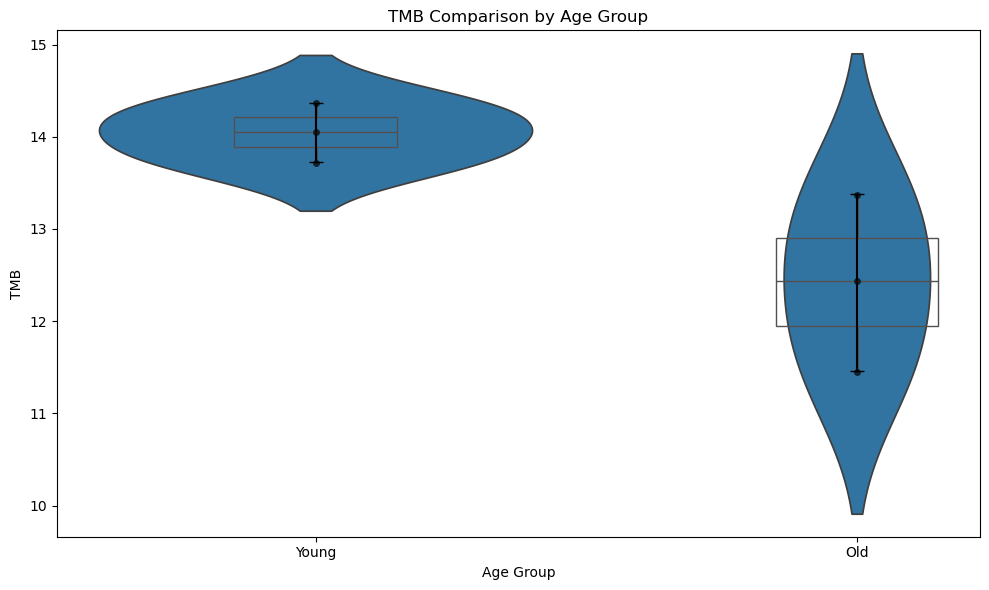

In [14]:
plot_df = pd.DataFrame(plot_data)

# Prepare data for the box violin plot
summary_data = []

print(tmb_dict)
for sample, tmb in tmb_dict.items():
    age_group = 'Old' if sample_order.index(sample) >= len(sample_order) - 3 else 'Young'
    summary_data.append({
        'Sample': sample,
        'Age Group': age_group,
        'TMB': tmb
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(by='Sample', ascending=False)
print(summary_df)

# Create the box violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Age Group', y='TMB', data=summary_df, inner=None)
sns.boxplot(x='Age Group', y='TMB', data=summary_df, whis=1.5, width=0.3, showcaps=False, boxprops={'facecolor':'None'}, showfliers=False, whiskerprops={'linewidth':2})
sns.swarmplot(x='Age Group', y='TMB', data=summary_df, color='black', alpha=0.7)

# Customize the plot
plt.title('TMB Comparison by Age Group')
plt.xlabel('Age Group')
plt.ylabel('TMB')

# Add error bars (standard deviation) to the plot
for age_group in summary_df['Age Group'].unique():
    group_data = summary_df[summary_df['Age Group'] == age_group]['TMB']
    mean = group_data.mean()
    std = group_data.std()
    plt.errorbar(x=[age_group], y=[mean], yerr=[std], fmt='none', c='k', capsize=5)

# Adjust layout and show the plot
plt.tight_layout()

# Save the plot as an SVG file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "young_old_tmb.svg")
plt.savefig(output_file, format='svg')

# Print TMB values in the correct order
for sample in sample_order:
    print(f"{sample}: TMB = {tmb_dict[sample]:.2f}")

## Using a k-means classifier to determine if the tumors are mutationally different

In [15]:
import pandas as pd

# Load the OncoKB database file
file_path = 'cancerGeneList.tsv'
oncokb_df = pd.read_csv(file_path, sep='\t')

# Function to classify genes using the OncoKB database
def classify_genes_oncokb(gene_list, oncokb_df):
    tsg_list = oncokb_df[oncokb_df['Is Tumor Suppressor Gene'] == 'Yes']['Hugo Symbol'].tolist()
    oncogene_list = oncokb_df[oncokb_df['Is Oncogene'] == 'Yes']['Hugo Symbol'].tolist()

    tsgs = [gene for gene in gene_list if gene in tsg_list]
    oncogenes = [gene for gene in gene_list if gene in oncogene_list]

    return tsgs, oncogenes
for key, item in symbol_dict.items():
    print(key)
    gene_symbols = list(set(item["Gene Symbol"].tolist()))
    tsgs, oncogenes = classify_genes_oncokb(gene_symbols, oncokb_df)
    print("Tumor Suppressor Genes:", tsgs)
    print("Oncogenes:", oncogenes)

102_tumor_vs_102_spleen
Tumor Suppressor Genes: ['TCF7L2', 'ERCC5', 'FANCD2', 'SETD2', 'TBX3', 'CASP8']
Oncogenes: ['NCOA3', 'SETD1A', 'UBR5', 'SMO', 'MLLT10', 'MAPK3', 'ARHGEF28']
116_tumor_vs_116_spleen
Tumor Suppressor Genes: ['HLA-B', 'DICER1', 'APC', 'PPP2R1A', 'NF1', 'POLE', 'HLA-A', 'EIF2B1', 'HLA-C']
Oncogenes: ['STAT3', 'MTOR']
107_tumor_vs_107_spleen
Tumor Suppressor Genes: ['BRCA1', 'HLA-B', 'BCOR', 'PRKDC', 'RECQL4', 'MYH11', 'NF1', 'PRPF8', 'HLA-A', 'DTX1', 'HLA-C']
Oncogenes: ['FLT3', 'PRKDC', 'COL1A1', 'FGFR3', 'INSR', 'ITPKB', 'AKT2']
158_tumor_vs_158_spleen
Tumor Suppressor Genes: ['HLA-B', 'KMT2D', 'EP400', 'PTPN13', 'KMT2A', 'IKZF3', 'PDS5B', 'TSC2', 'SESN3', 'HLA-A', 'POT1', 'HLA-C']
Oncogenes: ['ETV4', 'MYCN', 'COP1', 'SRC', 'HRAS', 'IKZF3', 'DNMT1', 'ECSIT', 'NRG1']
167_tumor_vs_167_spleen
Tumor Suppressor Genes: ['RUNX1', 'HLA-B', 'BCOR', 'RAD50', 'CREBBP', 'ZBTB20', 'PTPRS', 'TP63', 'HLA-A', 'INPP4B', 'ETS1', 'HLA-C']
Oncogenes: ['PLCG2', 'MN1', 'EPHB4', 'ZBTB20

In [16]:
set_old = []
set_young = []
old_keys = ["102", "107", "116"]
young_keys = ["157", "158", "167"]
for key, item in symbol_dict.items():
    print(key)
    if any(old_key in key for old_key in old_keys):
        set_old.append(list(set(item["Gene Symbol"].tolist())))
    elif any(young_key in key for young_key in young_keys):
        set_young.append(list(set(item["Gene Symbol"].tolist())))

print(len(set_old))
print(len(set_young))

102_tumor_vs_102_spleen
116_tumor_vs_116_spleen
107_tumor_vs_107_spleen
158_tumor_vs_158_spleen
167_tumor_vs_167_spleen
157_tumor_vs_157_spleen
3
3


In [17]:
# Step 1: Collect unique gene symbols
all_genes = set()
for key, item in symbol_dict.items():
    all_genes.update(item['Gene Symbol'].tolist())

# Convert set to sorted list
all_genes = sorted(all_genes)

# Step 2: Create the binary matrix
binary_matrix = pd.DataFrame(0, index=all_genes, columns=symbol_dict.keys())

# Step 3: Fill the binary matrix
for key, item in symbol_dict.items():
    gene_list = set(item['Gene Symbol'].tolist())
    binary_matrix.loc[binary_matrix.index.isin(gene_list), key] = 1

# Print the binary matrix
print(binary_matrix)



binary_matrix.to_csv("Genes_Mutated.csv")

         102_tumor_vs_102_spleen  116_tumor_vs_116_spleen  \
A1BG                           0                        0   
A3GALT2                        0                        0   
AACS                           0                        1   
AADACL3                        0                        0   
AANAT                          0                        0   
...                          ...                      ...   
ZSWIM2                         0                        0   
ZW10                           0                        0   
ZYG11B                         1                        0   
ZYX                            1                        0   
ZZEF1                          0                        0   

         107_tumor_vs_107_spleen  158_tumor_vs_158_spleen  \
A1BG                           0                        1   
A3GALT2                        0                        1   
AACS                           0                        0   
AADACL3                

Rat 102 (from Old) is in cluster 1
Rat 107 (from Old) is in cluster 0
Rat 116 (from Old) is in cluster 1
Rat 157 (from Young) is in cluster 0
Rat 158 (from Young) is in cluster 1
Rat 167 (from Young) is in cluster 1


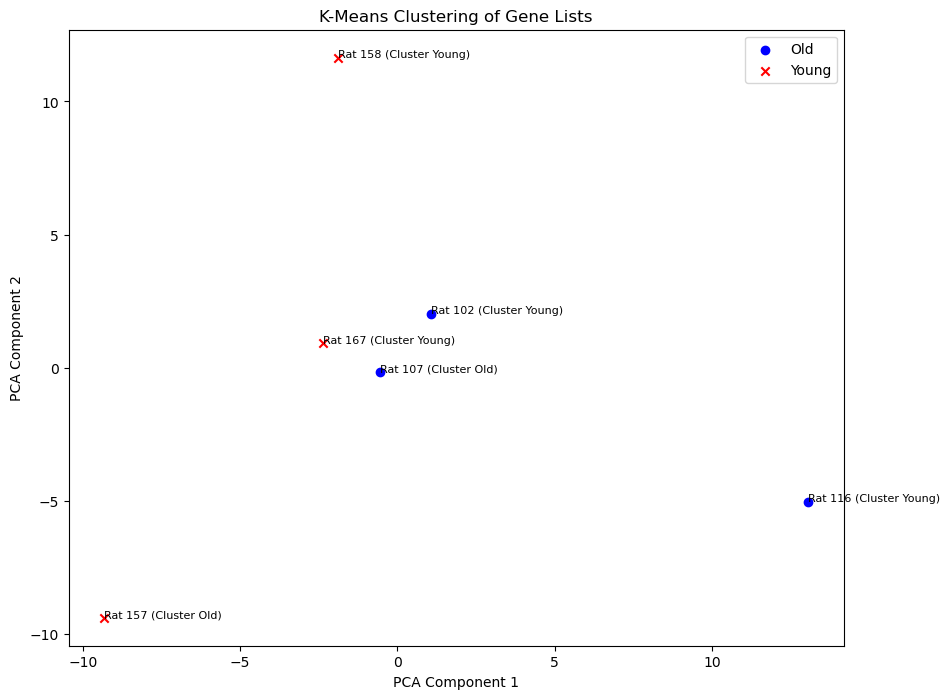

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Data from above
list1 = set_old
list2 = set_young
# Combine the lists
combined_lists = list1 + list2

# Flatten the lists to create a corpus for vectorization
corpus = [' '.join(gene_list) for gene_list in combined_lists]

# Create a binary matrix using CountVectorizer
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(corpus).toarray()

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)

# Get the cluster labels
labels = kmeans.labels_

# Perform PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the results
plt.figure(figsize=(10, 8))

for i in range(len(labels)):
    if i < len(list1):
        plt.scatter(X_pca[i, 0], X_pca[i, 1], color='blue', label='Old' if i == 0 else "", marker='o')
    else:
        plt.scatter(X_pca[i, 0], X_pca[i, 1], color='red', label='Young' if i == len(list1) else "", marker='x')

all_keys = old_keys + young_keys


# Labeling the clusters
for i in range(len(labels)):
    rat_num = all_keys[i]
    predicted_label = 'Old' if labels[i] == 0 else 'Young'
    plt.annotate(f"Rat {rat_num} (Cluster {predicted_label})", (X_pca[i, 0], X_pca[i, 1]), fontsize=8)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering of Gene Lists')
plt.legend()
# Save the plot as an SVG file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "cluster_kmeans.svg")
plt.savefig(output_file, format='svg')


# Print the results
for i, cluster in enumerate(labels):
    rat_num = all_keys[i]
    origin = 'Old' if i < len(list1) else 'Young'
    print(f"Rat {rat_num} (from {origin}) is in cluster {cluster}")


# Mutational Signature Analysis (SigProfiler Assignment)

In [19]:
from SigProfilerMatrixGenerator import install as genInstall

In [20]:
genInstall.install('rn6')

Tool       | Installed 
-----------------------
curl       | True      
wget       | True      
rsync      | True      


INFO - rn6 is already installed.


All reference files have been created.
To proceed with matrix_generation, please provide the path to your vcf files and an appropriate output path.
Installation complete.


In [21]:
# Path to the input somatic mutations file (if using segmentation file/mutational matrix) or input folder (mutation calling file/s).
samples = "/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/NeilRatWES/RatWES_Mutect2_VCF_Input"
# Path to the output folder.
output = "/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/NeilRatWES/RatWES_SigProfilerAssignmentOutput/"

In [22]:
import SigProfilerAssignment as spa
from SigProfilerAssignment import Analyzer as Analyze


Analyze.cosmic_fit(samples=samples, 
                   output=output,
                   input_type="vcf",
                   context_type="96",
                   genome_build="rn6",
                   cosmic_version=3.4)

Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 13.84 seconds.
Starting matrix generation for INDELs...Completed! Elapsed time: 5.66 seconds.
Matrices generated for 6 samples with 17127 errors. Total of 510758 SNVs, 20400 DINUCs, and 41537 INDELs were successfully analyzed.
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 6/6 [100%] in 10.9s (0.55/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


           SBS1  SBS2  SBS3   SBS4   SBS5  SBS6  SBS7a  SBS7b  SBS7c  SBS7d  \
Samples                                                                       
Rat_Y_167  1332     0     0  15614  27661     0      0      0      0      0   
Rat_Y_158  1127     0     0  13701  24603     0      0      0      0      0   
Rat_Y_157  1232     0     0      0  22368     0      0      0      0      0   
Rat_O_116  1482     0     0  17402  27942     0      0      0      0      0   
Rat_O_107  1202     0     0  18827  21455     0      0      0      0      0   
Rat_O_102  1304     0     0  18104  25062     0      0      0      0      0   

           ...  SBS90  SBS91  SBS92  SBS93  SBS94  SBS95  SBS96  SBS97  SBS98  \
Samples    ...                                                                  
Rat_Y_167  ...      0      0      0      0      0      0      0      0      0   
Rat_Y_158  ...      0      0      0      0      0      0      0      0      0   
Rat_Y_157  ...      0      0      0      0 

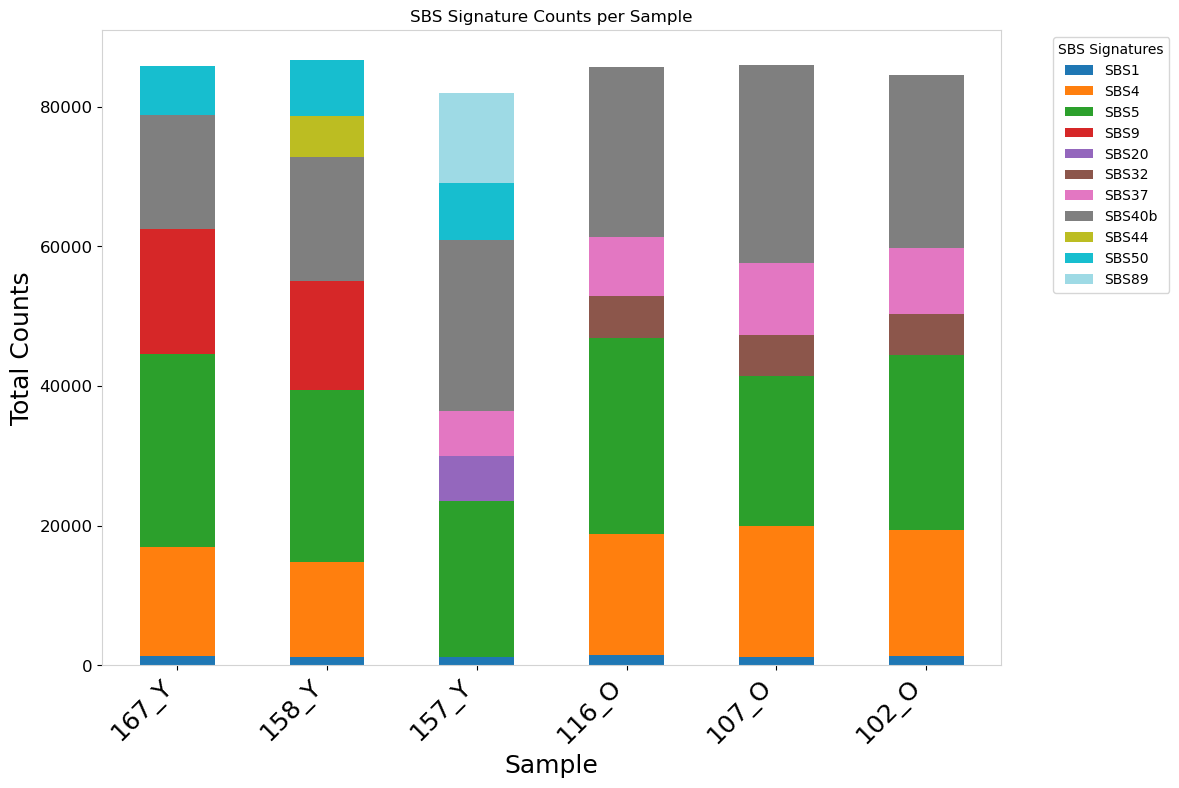

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

def plot_sbs_signatures(file_path):
    # Read the file into a DataFrame
    try:
        df = pd.read_csv(file_path, sep='\t')
    except Exception as e:
        print(f"Error reading the file: {e}")
        return
    
    # Check if DataFrame is correctly loaded
    if df.empty:
        print("DataFrame is empty. Please check the file content.")
        return

    # Set 'Samples' column as the index
    df.set_index('Samples', inplace=True)

    df = df.sort_index(ascending=False)
    print(df)
    # Drop columns where all values are zero
    df = df.loc[:, (df != 0).any(axis=0)]

    ax = df.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
    ax.set_ylabel('Total Counts', fontsize = 18)
    ax.set_xlabel('Sample', fontsize = 18)
    ax.set_title('SBS Signature Counts per Sample')
    plt.legend(title='SBS Signatures', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    # Modify x-axis labels
    current_labels = plt.gca().get_xticklabels()
    num_labels = len(current_labels)
    
    # Create new labels
    new_labels = []
    for i, label in enumerate(current_labels):
        suffix = '_Y' if i < 3 else '_O' if i >= num_labels - 3 else 'Rat '
        new_labels.append(label.get_text()[-3:] + suffix)
    plt.gca().set_xticklabels(new_labels, fontsize = 18)
    # Increase y-tick label font size
    plt.yticks(fontsize=12)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Save the plot as an SVG file
    output_dir = "output_plots"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "sigprofiler.svg")
    plt.savefig(output_file, format='svg')
    
    print(f"Plot saved as {output_file}")

# Path to the output folder.
output = "/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/NeilRatWES/RatWES_SigProfilerAssignmentOutput/"

# Example usage
file_path = os.path.join(output, 'Assignment_Solution/Activities/Assignment_Solution_Activities.txt')

plot_sbs_signatures(file_path)


In [24]:
import os
import pandas as pd
import pyranges as pr
from gtfparse import read_gtf

# Step 1: Read CNVKit .cns files
def read_cns_file(cns_file):
    cns_data = pd.read_csv(cns_file, sep='\t', low_memory=False)
    return cns_data

# Step 2: Convert CNVKit data to PyRanges format
def cns_to_pyranges(cns_data):
    cns_data = cns_data.rename(columns={'chromosome': 'Chromosome', 'start': 'Start', 'end': 'End'})
    pr_cns = pr.PyRanges(cns_data)
    return pr_cns

# Step 3: Annotate bins with genes using a GTF file
def annotate_bins_with_genes(pr_cns, gtf_file):
    gtf_data = read_gtf(gtf_file, result_type="pandas")
    gtf_data = gtf_data[gtf_data['feature'] == 'gene']
    gtf_data = gtf_data.rename(columns={'seqname': 'Chromosome', 'start': 'Start', 'end': 'End', 'gene_id': 'Gene'})
    pr_gtf = pr.PyRanges(gtf_data)
    annotated = pr_cns.join(pr_gtf, suffix='_gene')
    return annotated

# Step 4: Filter and summarize the genes with copy number changes
def summarize_gene_changes(annotated_df, sample_name):
    gain_threshold = 0  # Adjust threshold as needed
    loss_threshold = 0  # Adjust threshold as needed

    annotated_df = annotated_df.df
    annotated_df['change'] = annotated_df['log2'].apply(lambda x: x if x > gain_threshold or x < loss_threshold else None)
    changed_genes = annotated_df[annotated_df['change'].notnull()]
    
    gene_summary = changed_genes[['Gene', 'change']].drop_duplicates(subset=['Gene'])
    gene_summary = gene_summary.set_index('Gene').rename(columns={'change': sample_name})
    return gene_summary

# Main function to process the files
def process_cns_files(cns_files, gtf_file):
    all_gene_changes = []
    
    for cns_file in cns_files:
        sample_name = os.path.basename(cns_file).split(".")[0]  # Extract sample name from file name
        cns_data = read_cns_file(cns_file)
        pr_cns = cns_to_pyranges(cns_data)
        annotated_df = annotate_bins_with_genes(pr_cns, gtf_file)
        gene_changes = summarize_gene_changes(annotated_df, sample_name)
        all_gene_changes.append(gene_changes)

    # Ensure all gene IDs are unique across the combined DataFrame
    combined_gene_changes = pd.concat(all_gene_changes, axis=1)
    combined_gene_changes = combined_gene_changes.loc[~combined_gene_changes.index.duplicated(keep='first')].fillna('neutral')
    return combined_gene_changes

# Example usage
cns_files = [
    "/bgfs/alee/LO_LAB/General/Lab_Data/20240628_WES_Rat_Neil/results/variant_calling/cnvkit/102_tumor_vs_102_spleen/102_tumor.md.cns",
    "/bgfs/alee/LO_LAB/General/Lab_Data/20240628_WES_Rat_Neil/results/variant_calling/cnvkit/107_tumor_vs_107_spleen/107_tumor.md.cns",
    "/bgfs/alee/LO_LAB/General/Lab_Data/20240628_WES_Rat_Neil/results/variant_calling/cnvkit/116_tumor_vs_116_spleen/116_tumor.md.cns",
    "/bgfs/alee/LO_LAB/General/Lab_Data/20240628_WES_Rat_Neil/results/variant_calling/cnvkit/157_tumor_vs_157_spleen/157_tumor.md.cns",
    "/bgfs/alee/LO_LAB/General/Lab_Data/20240628_WES_Rat_Neil/results/variant_calling/cnvkit/158_tumor_vs_158_spleen/158_tumor.md.cns",
    "/bgfs/alee/LO_LAB/General/Lab_Data/20240628_WES_Rat_Neil/results/variant_calling/cnvkit/167_tumor_vs_167_spleen/167_tumor.md.cns",
]  # Replace with your actual .cns file paths
gtf_file = "Rattus_norvegicus.Rnor_6.0.104.gtf"  # Replace with the path to your GTF file

gene_changes = process_cns_files(cns_files, gtf_file)
print(gene_changes.head())
gene_changes.to_csv("gene_changes_cns.csv")


INFO - Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'tag']
INFO - Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'tag']
INFO - Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'tag']
INFO - Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_ve

                    102_tumor 107_tumor 116_tumor  157_tumor 158_tumor  \
Gene                                                                     
ENSRNOG00000046319  -0.087785 -0.110073 -0.071536  -0.077791 -0.078913   
ENSRNOG00000047964  -0.087785 -0.110073 -0.071536  -0.077791 -0.078913   
ENSRNOG00000050370  -0.087785 -0.110073 -0.071536  -0.077791 -0.078913   
ENSRNOG00000032365  -0.087785 -0.110073 -0.071536  -0.077791 -0.078913   
ENSRNOG00000040300  -0.087785 -0.110073 -0.071536  -0.077791 -0.078913   

                    167_tumor  
Gene                           
ENSRNOG00000046319  -0.111423  
ENSRNOG00000047964  -0.111423  
ENSRNOG00000050370  -0.111423  
ENSRNOG00000032365  -0.111423  
ENSRNOG00000040300  -0.111423  
